# AIC & BIC

In [1]:
# Standard imports and abbreviations
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Tools and metrics for ridge regression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Needed to provide type hints for functions passed as arguments
from typing import Callable

The Akaike Information Criterion (AIC) is a statistical metric used for model selection, particularly in the context of regression analysis and statistical modeling. AIC is designed to balance the trade-off between the goodness of fit of a model and its complexity. In other words, AIC helps you choose a model that fits the data well while penalizing overly complex models.

The formula for AIC is as follows:
$$AIC = 2k - 2 \ell$$

where:

- $k$ is the number of estimated parameters in the model, and
- $\ell$ is the natural logarithm of the maximum likelihood (likelihood of the data given the model)

The goal of AIC is to find the model with the lowest AIC value among a set of candidate models. Lower AIC values indicate a better trade-off between model fit and complexity. Therefore, the model with the lowest AIC is often considered the most appropriate model for explaining the data.

In [2]:
def calculate_aic(y:np.ndarray, y_pred:np.ndarray, 
                  num_params:int) -> float:
    """
    Calculate AIC (Akaike Information Criterion) for a least squares regression type model with normally distributed errors.
    """
    
    if len(y) != len(y_pred):
        raise ValueError("Input arrays y and y_pred must have the same length.")
    
    n = len(y)
    residual_error = y - y_pred
    mse = np.mean(residual_error ** 2)
    aic = n * np.log(mse) + 2 * num_params
    
    return aic

The Bayesian Information Criterion (BIC), also known as the Schwarz criterion, is a statistical metric used for model selection in the context of regression analysis and statistical modeling. BIC, similar to AIC, helps strike a balance between model fit and model complexity but uses a slightly different approach.

The formula for BIC is as follows:
$$BIC = -2\ell + k\ln(n)$$

where:

- $k$ is the number of estimated parameters in the model,
- $\ell$ is the natural logarithm of the maximum likelihood (likelihood of the data given the model), and
- $n$ is the number of data points in the dataset.
  
The key difference between AIC and BIC lies in the penalty term for model complexity. While both AIC and BIC penalize models for having more parameters, BIC imposes a stronger penalty for additional parameters. This stronger penalty for complexity in BIC means that BIC tends to favor simpler models with fewer parameters compared to AIC.

In [3]:
def calculate_bic(y:np.ndarray, y_pred:np.ndarray, 
                  num_params:int) -> float:
    """
    Calculate BIC (Bayesian Information Criterion) for a least squares regression type model with normally distributed errors.
    """

    if len(y) != len(y_pred):
        raise ValueError("Input arrays y and y_pred must have the same length.")
    
    n = len(y)
    residual_error = y - y_pred
    mse = np.mean(residual_error ** 2)
    bic = n * np.log(mse) + num_params * np.log(n)
    
    return bic

Let's see these two criteria at work with a ridge regression model. Let's start with a syntehtic dataset. 

In [4]:
# Generate synthetic data
np.random.seed(13)
X = np.linspace(0, 10, 250)
y = 2*X + 1 + np.random.normal(0, 0.5, 250)  # Generate noisy data

# Used for plotting results and ground truth
X_range = np.linspace(0, 10, 500)
y_truth = 2*X_range + 1

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=13)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=13)

# for fitting the function once hyperparameters are selected
X_train_val = np.concatenate((X_train, X_val))
y_train_val = np.concatenate((y_train, y_val))

Here, we can graph the results of a single choice of $\lambda$ (also referred to as $\alpha$ in the code) to get a sense of the data, the model, and the plot. Remember, however, that our goal is model selection--we want to select a value of $\lambda$ best suited to the data. 

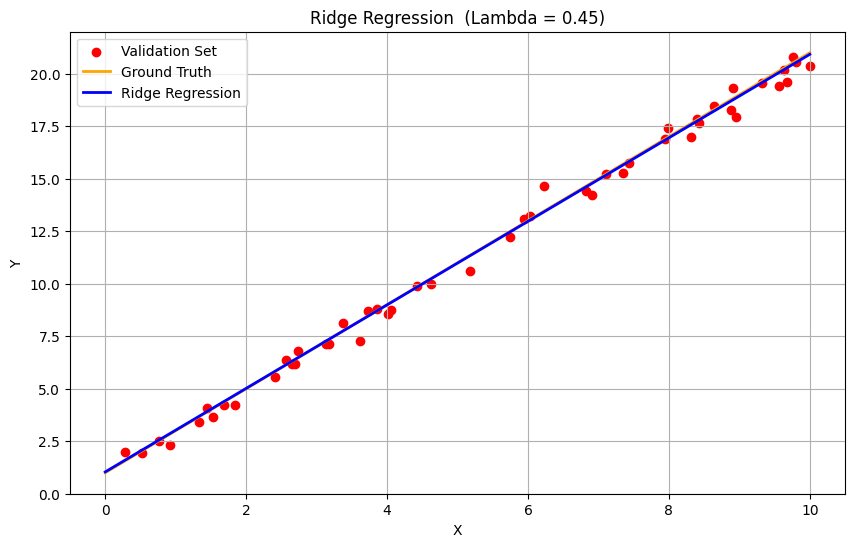

In [5]:
lam = 0.45

# Create and train a Ridge Regression model
ridge = Ridge(alpha=lam) 

# Reshape the input data to 2D arrays
X_train_2d = X_train.reshape(-1, 1)  # Reshape X_train to have one feature
X_range_2d = X_range.reshape(-1, 1)  # Reshape X_range to have one feature

# Fit the model using the 2D arrays
ridge.fit(X_train_2d, y_train)

# Predict using the 2D array
y_pred_plot = ridge.predict(X_range_2d)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(X_val, y_val, color='red', label='Validation Set')
plt.plot(X_range, y_truth, label=f'Ground Truth', color='orange', linewidth=2)
plt.plot(X_range, y_pred_plot, color='blue', lw=2, label=f'Ridge Regression')
plt.title(f'Ridge Regression  (Lambda = {lam})')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

Now, let us consider a range of $\lambda$ values and make the selection based on AIC and BIC. Generally, these will match up when the competing models have the same number of inputs. All of the models under consideration have 1 input.

We will also plot both metrics against the possibilities at the end to illustrate where the minimums are achieved. Remember, the lower these score the better the model. 

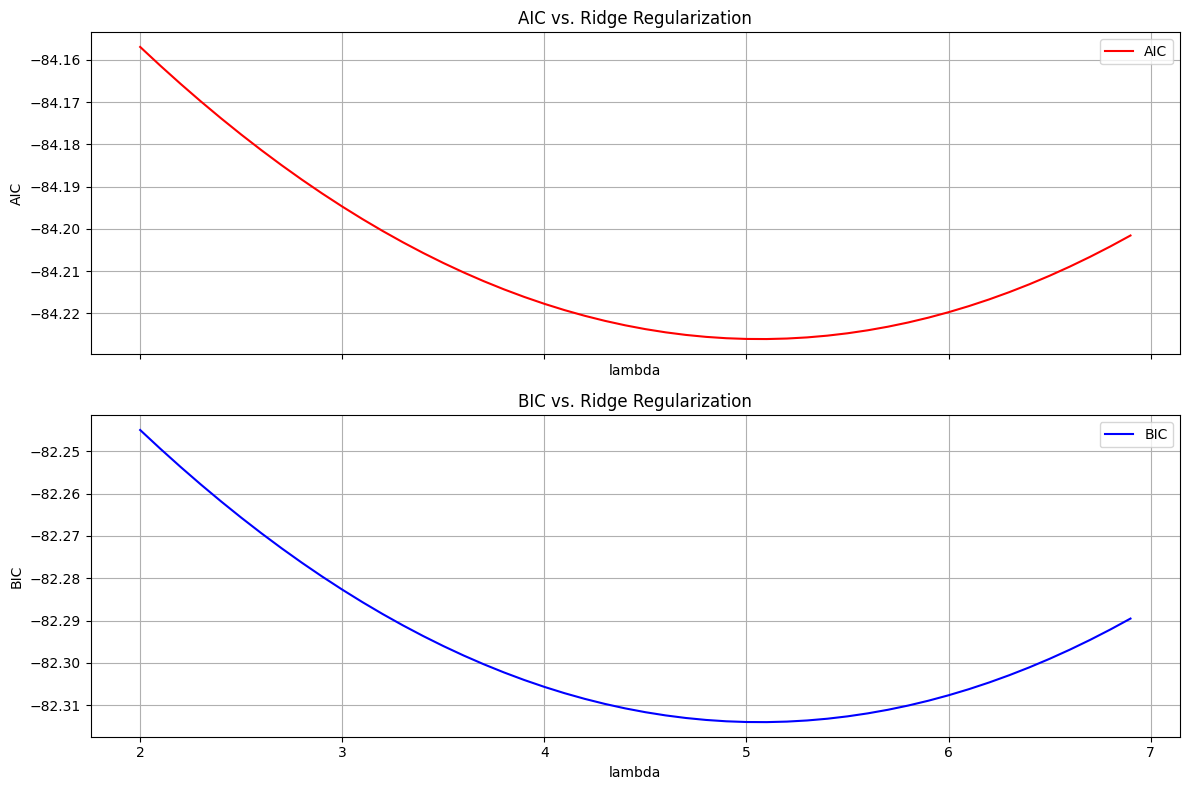

In [6]:
# Reshape X_val to have one feature
X_val_2d = X_val.reshape(-1, 1)  

# Create a range of lambda values
lambdas = np.arange(2, 7, 0.1)

# Initialize arrays to store coefficients and MSE values
coefficients = [] 
aic_values = []
bic_values = []

# Fit Ridge Regression models and calculate MSE for different lambda values
for lam in lambdas:
    ridge = Ridge(alpha=lam) 
    ridge.fit(X_train_2d , y_train) 
    coefficients.append(ridge.coef_)
    
    y_val_pred = ridge.predict(X_val_2d)
    aic = calculate_aic(y_val, y_val_pred, len(ridge.coef_))
    aic_values.append(aic)
    bic = calculate_bic(y_val, y_val_pred, len(ridge.coef_))
    bic_values.append(bic)

# Create a subplot with two plots (coefficient paths and MSE values)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot the AIC values
ax1.plot(lambdas, aic_values , color='red', label='AIC') 
ax1.set_xlabel('lambda')
ax1.set_ylabel('AIC')
ax1.set_title('AIC vs. Ridge Regularization')
ax1.legend() 
ax1.grid()

# Plot the BIC values
ax2.plot(lambdas, bic_values , color='blue', label='BIC') 
ax2.set_xlabel('lambda')
ax2.set_ylabel('BIC')
ax2.set_title('BIC vs. Ridge Regularization')
ax2.legend() 
ax2.grid()

plt.tight_layout()
plt.show()

Now let's see the actual $\lambda$ value where this minimum is achieved. 

In [7]:
best_lambda_aic = round(lambdas[np.argmin(aic_values)], 2)
print(f"Best lambda based on validation set AIC: {best_lambda_aic}")
best_lambda_bic = round(lambdas[np.argmin(bic_values)], 2)
print(f"Best lambda based on validation set BIC: {best_lambda_aic}")

Best lambda based on validation set AIC: 5.1
Best lambda based on validation set BIC: 5.1


We now select one of the two possible lambda values and compute our model. We evaluate the model's efficacy using the testing set. 

AIC on testing set with best lambda (5.1): -78.9212
BIC on testing set with best lambda (5.1): -77.0092
Mean Squared Error on testing set with best lambda (5.1): 0.1982
R-squared on testing set with best lambda (5.1): 0.9940


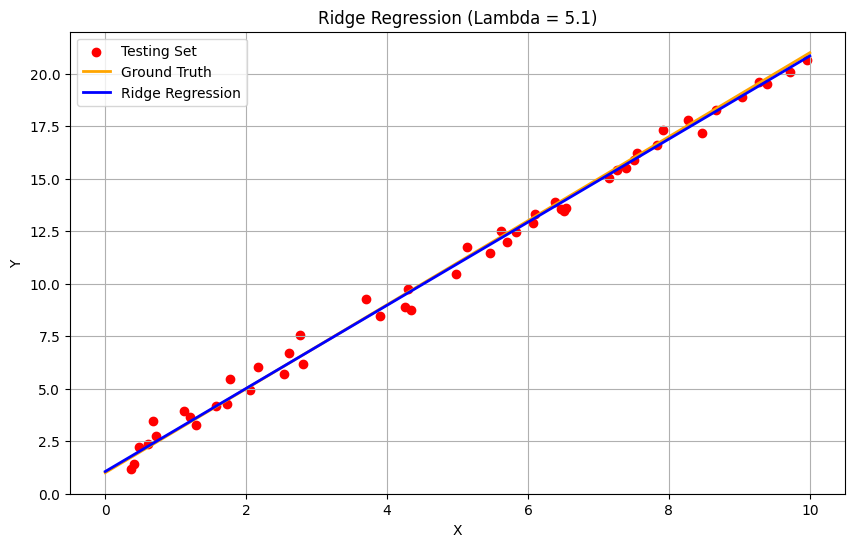

In [8]:
best_lambda = best_lambda_aic

# Reshape the input data to 2D arrays
X_train_val_2d = X_train_val.reshape(-1, 1)
X_test_2d = X_test.reshape(-1, 1)

# Fit the model using the 2D arrays
ridge.fit(X_train_val_2d, y_train_val)

# Predict using the 2D array
y_pred_plot = ridge.predict(X_range_2d)
y_pred_test = ridge.predict(X_test_2d)

# Calculate AIC, BIC, MSE and R2 on the testing set
test_aic = calculate_aic(y_test, y_pred_test, len(ridge.coef_))
test_bic = calculate_bic(y_test, y_pred_test, len(ridge.coef_))
test_mse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

print(f"AIC on testing set with best lambda ({best_lambda}): {test_aic:.4f}")
print(f"BIC on testing set with best lambda ({best_lambda}): {test_bic:.4f}")
print(f"Mean Squared Error on testing set with best lambda ({best_lambda}): {test_mse:.4f}")
print(f"R-squared on testing set with best lambda ({best_lambda}): {test_r2:.4f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='red', label='Testing Set')
plt.plot(X_range, y_truth, label=f'Ground Truth', color='orange', linewidth=2)
plt.plot(X_range, y_pred_plot, color='blue', lw=2, label=f'Ridge Regression')
plt.title(f'Ridge Regression (Lambda = {best_lambda})')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

Finally, it is important to note that this example does not illustrate the full power of AIC and BIC because the example does not have the possibility of multiple inputs. Models comparing different numbers of inputs (such as a subset selection method) work much better with AIC and BIC. We opted for ridge regression, however, so that we could visualize the data and the plots. 